In [33]:
import torch, torchvision.transforms as T
from torchvision import models
from PIL import Image
import os, glob, pandas as pd, numpy as np, scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

## alexnet stuff

In [2]:
# load pretrainded AlexNet model
model = models.alexnet(weights=AlexNet_Weights.DEFAULT).eval()
# remove the last layer to get the feature vector
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# transform the input image to the format expected by the model
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_embeddings(img_path):
    img = transform(Image.open(img_path).convert('RGB')).unsqueeze(0)
    with torch.no_grad():
    # with torch.no_grad() is used to disable gradient calculation
        return model(img)

## get embeddings of stims used in expt

In [3]:
# # get list of shapes used as targets
# trials_df = pd.read_csv('../input_data/trials.csv')
# shape_files_used = trials_df['target_file'].tolist()
# embeddings = [(shape_file, get_embeddings(os.path.join('../', shape_file))) for shape_file in shape_files_used]

# # convert to df
# embeddings_df = pd.DataFrame([(k, *v.squeeze().numpy()) for k, v in embeddings])
# embeddings_df.columns = ['shapes'] + [f'feature_{i}' for i in range(embeddings_df.shape[1] - 1)]

# # append associated stim & noise positions
# embeddings_df['stim_file_pos'] = trials_df['stim_file_pos']
# embeddings_df['noise_pos'] = trials_df['noise_pos']
# reorder_columns = ['shapes', 'stim_file_pos', 'noise_pos'] + [col for col in embeddings_df.columns if col.startswith('feature_')]
# embeddings_df = embeddings_df[reorder_columns]

# # remove features with minimal variance across shapes
# feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]
# variances = embeddings_df[feature_cols].var()
# threshold = 0.2
# low_variance_features = variances[variances < threshold].index
# embeddings_df = embeddings_df.drop(columns=low_variance_features)

# embeddings_df.to_csv('../input_data/stimuli_embeddings.csv', index=False)

embeddings_df = pd.read_csv('../input_data/stimuli_embeddings.csv')
print(len(embeddings_df))
embeddings_df.head()


240


,shapes,stim_file_pos,noise_pos,feature_38,feature_45,feature_47,feature_52,feature_60,feature_88,feature_89,...,feature_3978,feature_3989,feature_4029,feature_4058,feature_4062,feature_4068,feature_4072,feature_4073,feature_4076,feature_4091
0,input_data/stims/Shape_0.10_1.00.png,0.1,1.0,0.0,4.321363,0.265191,10.104380,6.563837,0.897169,5.857170,...,1.309970,0.689861,16.736954,5.845687,1.352016,0.0,2.771213,5.519984,0.293255,0.0
1,input_data/stims/Shape_0.10_1.00.png,0.1,1.0,0.0,4.321363,0.265191,10.104380,6.563837,0.897169,5.857170,...,1.309970,0.689861,16.736954,5.845687,1.352016,0.0,2.771213,5.519984,0.293255,0.0
2,input_data/stims/Shape_0.30_1.00.png,0.3,1.0,0.0,5.103432,0.098392,10.506258,6.886869,0.451986,6.409008,...,0.974600,0.674793,16.914658,6.205310,1.119534,0.0,2.433510,5.862866,0.000000,0.0
3,input_data/stims/Shape_0.30_1.00.png,0.3,1.0,0.0,5.103432,0.098392,10.506258,6.886869,0.451986,6.409008,...,0.974600,0.674793,16.914658,6.205310,1.119534,0.0,2.433510,5.862866,0.000000,0.0
4,input_data/stims/Shape_0.50_1.00.png,0.5,1.0,0.0,5.420555,0.012235,10.232821,7.231481,1.283351,5.765145,...,1.027748,0.609162,16.070360,6.721252,0.987496,0.0,1.914770,5.642951,0.686270,0.0


## plot stim embeddings

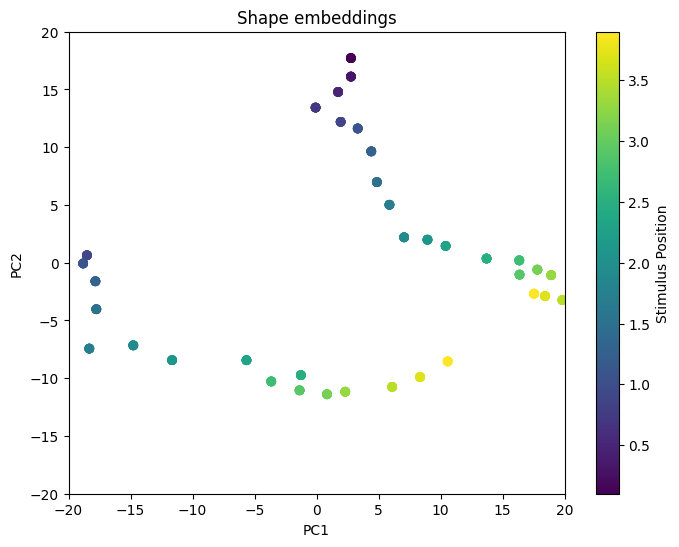

In [4]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_df.drop(columns=['shapes', 'stim_file_pos', 'noise_pos']))
reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])

reduced_embeddings_df['stim_file_pos'] = embeddings_df['stim_file_pos'].values
reduced_embeddings_df['noise_pos'] = embeddings_df['noise_pos'].values
reduced_embeddings_df.head()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings_df['PC1'], reduced_embeddings_df['PC2'], c=reduced_embeddings_df['stim_file_pos'])
# scatter = plt.scatter(reduced_embeddings_df['PC1'], reduced_embeddings_df['PC2'], c=reduced_embeddings_df['noise_pos'])
plt.colorbar(scatter, label='Stimulus Position')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title('Shape embeddings')
plt.show()


## building architecture

In [5]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim

class ShapeSideNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ShapeSideNN, self).__init__()
        
        # single intermediate layer
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        # separate outputs
        self.reconstruction_output = nn.Linear(hidden_dim, output_dim)
        self.classification_output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        
        # output for reconstruction (continuous)
        reconstruction = self.reconstruction_output(x)
        
        # output for classification (binary)
        classification = torch.sigmoid(self.classification_output(x))
        
        return reconstruction, classification

## format input data

In [44]:
# select feature cols and block (for now, divider in the middle) rows
feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]
block_rows = embeddings_df.iloc[list(range(40)) + list(range(120, 160))]

X_train = block_rows[feature_cols].values
y_recon_train = X_train.copy()
y_class_train = (block_rows['stim_file_pos'] >= 2).astype(int).values # binary classification (0 or 1)
print(type(X_train), type(y_recon_train), type(y_class_train))

# Ensure data is a tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_recon_train = torch.tensor(y_recon_train, dtype=torch.float32)
y_class_train = torch.tensor(y_class_train, dtype=torch.float32).unsqueeze(1)  # Ensure y_class_train is of shape (N, 1) for binary classification

print(X_train.shape, y_recon_train.shape, y_class_train.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
torch.Size([80, 405]) torch.Size([80, 405]) torch.Size([80, 1])


## train

Fold 1
Final Val Loss (Fold 1): Recon: 0.22571603953838348, Class: 0.48660820722579956
Fold 2
Final Val Loss (Fold 2): Recon: 0.29720473289489746, Class: 0.5414242744445801
Fold 3
Final Val Loss (Fold 3): Recon: 0.3162844479084015, Class: 0.5562527179718018
Fold 4
Final Val Loss (Fold 4): Recon: 0.29072126746177673, Class: 0.5228983163833618
Fold 5
Final Val Loss (Fold 5): Recon: 0.3157638609409332, Class: 0.5104837417602539


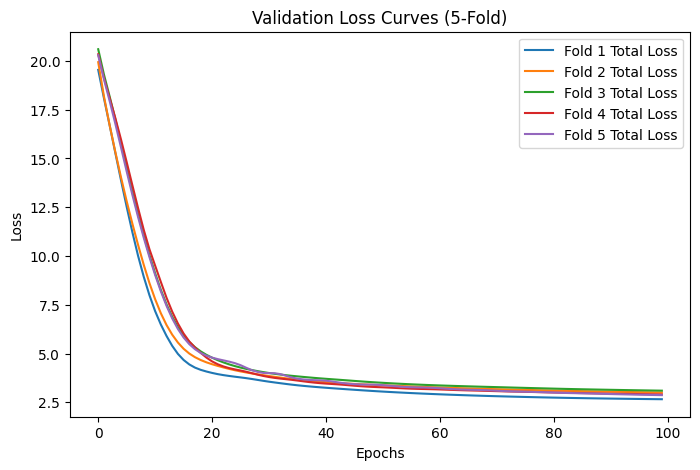

In [ ]:
from sklearn.model_selection import KFold

# # select feature cols and block (for now, divider in the middle) rows
# feature_cols = [col for col in embeddings_df.columns if col.startswith('feature_')]
# block_rows = embeddings_df.iloc[list(range(40)) + list(range(120, 160))]

# X_train = block_rows[feature_cols].values
# y_recon_train = X_train.copy()
# y_class_train = (block_rows['stim_file_pos'] >= 2).astype(int).values # binary classification (0 or 1)
# print(type(X_train), type(y_recon_train), type(y_class_train))

# architecture params
input_dim, hidden_dim, output_dim = 405, 128, 405
model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# loss params
recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
recon_wt, class_wt = 1, 5

# convert to numpy arrays for compatibility with KFold
X_train = np.array(X_train)
y_recon_train = np.array(y_recon_train)
y_class_train = np.array(y_class_train)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
# store losses for each fold
all_total_losses, all_recon_losses, all_class_losses = [], [], []

epochs = 100

# cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold+1}")

    # split into train and val
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_recon_train_fold, y_recon_val_fold = y_recon_train[train_idx], y_recon_train[val_idx]
    y_class_train_fold, y_class_val_fold = y_class_train[train_idx], y_class_train[val_idx]

    # initialize model, loss, and optimizer
    model = ShapeSideNN(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # store losses
    total_train_losses, train_recon_losses, train_class_losses = [], [], []
    total_val_losses, val_recon_losses, val_class_losses = [], [], []

    # training loop
    for epoch in range(epochs):
        model.train()

        # forward pass
        recon_pred, class_pred = model(torch.tensor(X_train_fold, dtype=torch.float32))
        class_pred = torch.sigmoid(class_pred)

        # calculate losses
        train_recon_loss = recon_loss_fn(recon_pred, torch.tensor(y_recon_train_fold, dtype=torch.float32))
        train_class_loss = class_loss_fn(class_pred, torch.tensor(y_class_train_fold, dtype=torch.float32))
        total_train_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

        # backward pass and optimization
        optimizer.zero_grad()
        total_train_loss.backward()
        optimizer.step()

        # store train losses
        train_recon_losses.append(train_recon_loss.item())
        train_class_losses.append(train_class_loss.item())
        total_train_losses.append(total_train_loss.item())

        # validation
        model.eval()
        with torch.no_grad():
            recon_val_pred, class_val_pred = model(torch.tensor(X_val_fold, dtype=torch.float32))
            class_val_pred = torch.sigmoid(class_val_pred)

            # calculate val losses
            val_recon_loss = recon_loss_fn(recon_val_pred, torch.tensor(y_recon_val_fold, dtype=torch.float32))
            val_class_loss = class_loss_fn(class_val_pred, torch.tensor(y_class_val_fold, dtype=torch.float32))
            total_val_loss = recon_wt * val_recon_loss + class_wt * val_class_loss

            # store val losses
            val_recon_losses.append(val_recon_loss.item())
            val_class_losses.append(val_class_loss.item())
            total_val_losses.append(total_val_loss.item())

    print(f"Final Val Loss (Fold {fold+1}): Recon: {val_recon_losses[-1]}, Class: {val_class_losses[-1]}")

    all_total_losses.append(total_val_losses)
    all_recon_losses.append(val_recon_losses)
    all_class_losses.append(val_class_losses)

# plot losses
plt.figure(figsize=(8, 5))
for i in range(5):
    plt.plot(all_total_losses[i], label=f'Fold {i+1} Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Curves (5-Fold)')
plt.legend()
plt.show()


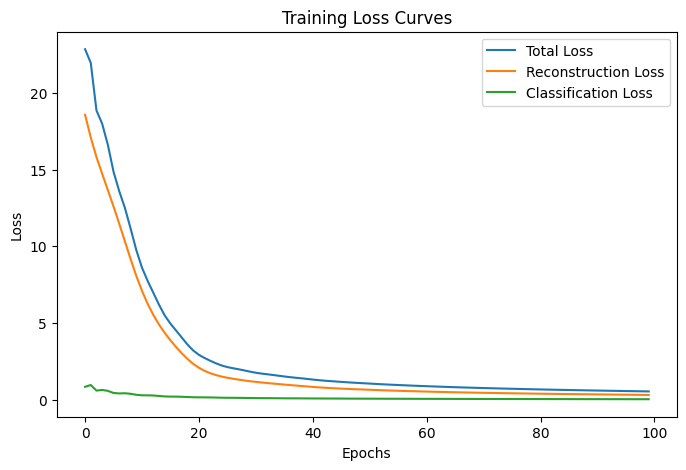

[0.8540897369384766, 0.9715385437011719, 0.6074413061141968, 0.6511172652244568, 0.5895030498504639, 0.45264458656311035, 0.4227064549922943, 0.43595990538597107, 0.3978341519832611, 0.3354812562465668, 0.3017086982727051, 0.29860395193099976, 0.28828251361846924, 0.25742775201797485, 0.22789493203163147, 0.21687762439250946, 0.2148275077342987, 0.20514217019081116, 0.18787534534931183, 0.1741519272327423, 0.1687542200088501, 0.1670011579990387, 0.16220790147781372, 0.15320442616939545, 0.14420107007026672, 0.1389247328042984, 0.13703879714012146, 0.13499398529529572, 0.13049429655075073, 0.12435229122638702, 0.11905530840158463, 0.11590249836444855, 0.11407516151666641, 0.11195190250873566, 0.10888522863388062, 0.10560933500528336, 0.10311862081289291, 0.1015690416097641, 0.10024683177471161, 0.09830990433692932, 0.09588031470775604, 0.09361644089221954, 0.09197888523340225, 0.09078748524188995, 0.08950527757406235, 0.08785240352153778, 0.08600527048110962, 0.08432796597480774, 0.0829

In [45]:
# store losses
total_train_losses, train_recon_losses, train_class_losses = [], [], []

# architecture params
input_dim, hidden_dim, output_dim = 405, 128, 405
model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# loss params
recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
recon_wt, class_wt = 1, 5

# training loop
epochs = 100
for epoch in range(epochs):
    
    # forward pass
    recon_pred, class_pred = model(X_train)
    
    # calculate losses
    train_recon_loss = recon_loss_fn(recon_pred, y_recon_train)
    train_class_loss = class_loss_fn(class_pred, y_class_train)
    total_train_loss = recon_wt * train_recon_loss + class_wt * train_class_loss
    
    # store losses
    train_recon_losses.append(train_recon_loss.item())
    train_class_losses.append(train_class_loss.item())
    total_train_losses.append(total_train_loss.item())
    
    # backward pass and optimization
    optimizer.zero_grad()
    total_train_loss.backward()
    optimizer.step()

    # if epoch % 10 == 0:
    #     print(f'Epoch {epoch}/{epochs}, Reconstruction Loss: {loss_recon.item()}, Classification Loss: {loss_class.item()}')

# plot losses
plt.figure(figsize=(8, 5))
plt.plot(total_train_losses, label='Total Loss')
plt.plot(train_recon_losses, label='Reconstruction Loss')
plt.plot(train_class_losses, label='Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()

print(train_class_losses)

## test

## visualize intermediate layer

In [9]:
xyz

NameError: name 'xyz' is not defined

In [ ]:
# 1. try just classification loss
# 2. try just reconstruction loss
# 3. try just asymmetric classification loss
# 4. try reconstruction + asymmetric loss
# 4. finally, remove asymmetry and add reward